# Tutorial: Basic PCA approaches

This lab focuses on principal component analysis and regression as well as partial least squares regression in R.

## Goals:
* Understand principal component analysis, and use it for visualization
* Implement principal component regression using `pcr()` in the `pls` library
* Implement partial least squares using `plsr()` in the `pls` library

This lab draws from the practice sets at the end of Chapter 6 in James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). "An introduction to statistical learning: with applications in r."

---
# Principal component analysis: the big picture

Principal component analysis (PCA) is a handy way to decrease the dimensionality of your data. PCA helps you identify the dimensions along which your data varies the most, so you can capture the important variance while also simplifying. 

This can be a bit hard to get a physical intuition for, so if you'd like more discussion about how to think about PCA and dimensionality reduction more generally, I'd recommend checking out [this video from StatQuest](https://www.youtube.com/watch?v=_UVHneBUBW0).

However, before we move on to PCR and PLS, let's do a quick example of applying PCA in a simple context. In this example, we'll focus on PCA as a tool for visualization using the `iris` dataset. This data set reports petal and sepal lengths for three different subspecies of iris flowers.

In [33]:
head(iris)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa


First, let's convince ourselves that there is some redundant information in this data set. How correlated are the four quantitative variables?

In [34]:
cor(iris[,1:4])

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
Sepal.Length,1.0000000,-0.1175698,0.8717538,0.8179411
Sepal.Width,-0.1175698,1.0000000,-0.4284401,-0.3661259
Petal.Length,0.8717538,-0.4284401,1.0000000,0.9628654
Petal.Width,0.8179411,-0.3661259,0.9628654,1.0000000


It looks like `Petal.Width` and `Petal.Length` are highly correlated with each other, and they're also both correlated with `Sepal.Length`.

Let's also plot how the three subspecies are distributed with respect to these variables. 

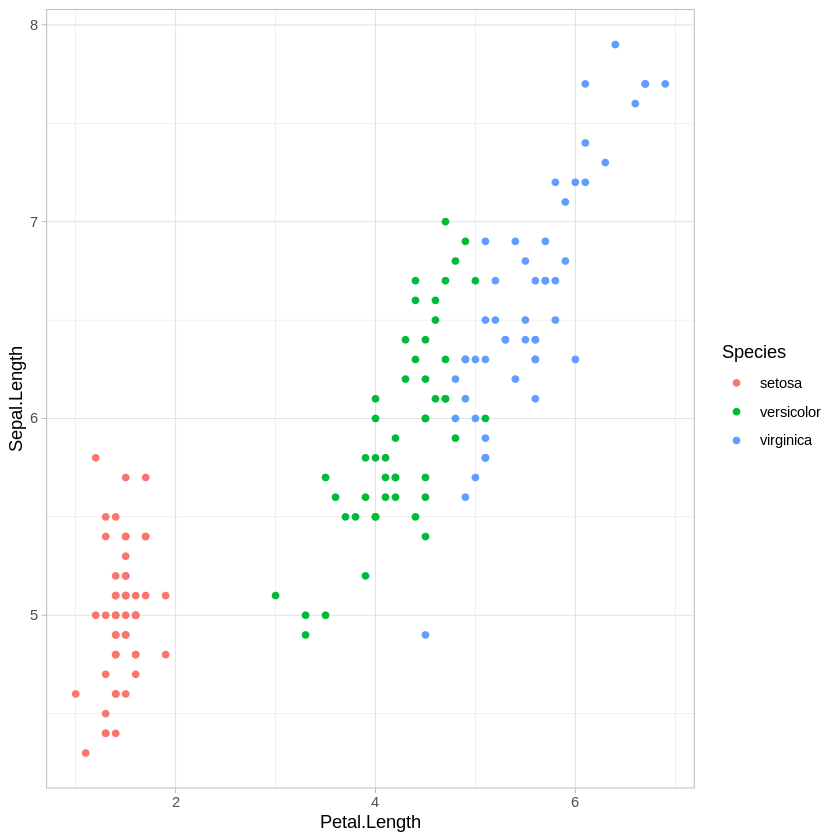

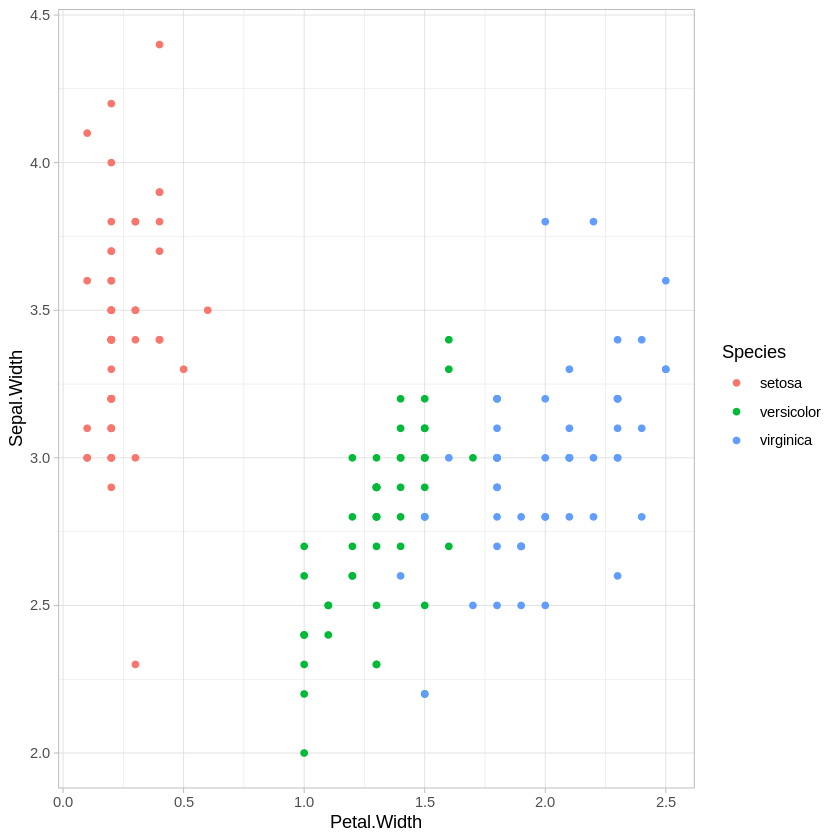

In [35]:
require(ggplot2)
ggplot(iris,aes(x=Petal.Length, y = Sepal.Length, col=Species)) + geom_point() + theme_light()
ggplot(iris,aes(x=Petal.Width, y = Sepal.Width, col=Species)) + geom_point() + theme_light()


There are other combinations of variables we could plot, of course, but this is enough to show that all of these variables are providing some information about how these species differ.

How can we decrease the dimensionality of this data from 4 variables to 2 without losing too much information? We'll use the `prcomp()` function to do this.

In [36]:
iris.pca <- prcomp(iris[,1:4],scale. = TRUE) 
# ^^ "scale." just indicates that all variables should be scaled before PCA is applied, so that units don't matter

The first thing we may want to look at is how much variance is explained by each of the components. The `sdev` attribute gives the square root of the eigenvalue for each component - we can turn this into percentages by just dividing by the sum of the vector.  

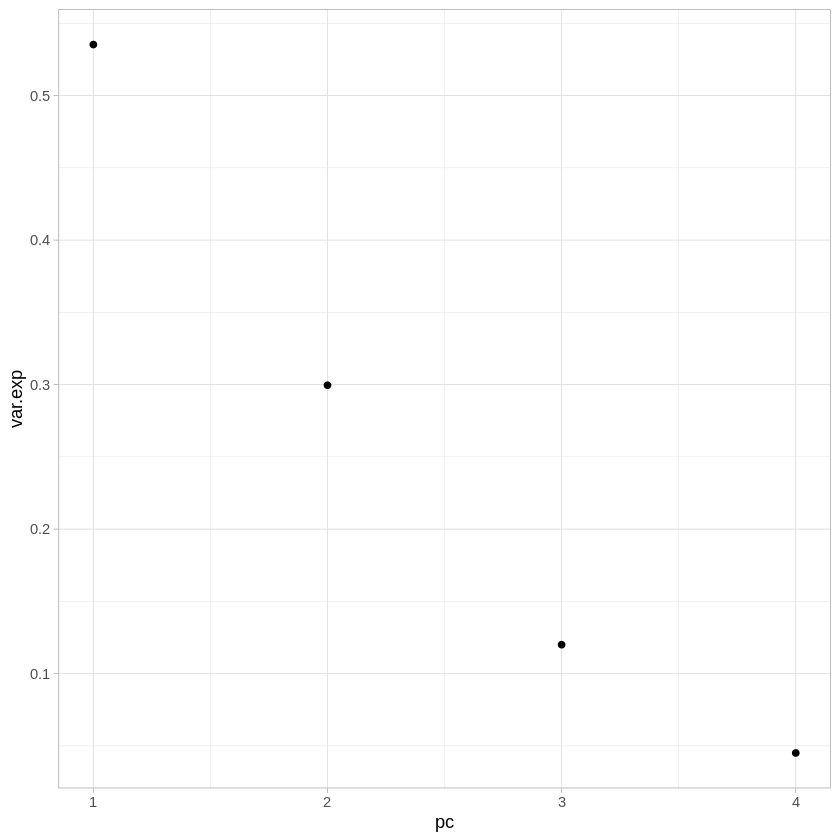

In [37]:
ggplot(data.frame(pc=1:4,var.exp=iris.pca$sdev/sum(iris.pca$sdev)),
        aes(x=pc,y=var.exp)) + 
    geom_point() + 
    theme_light()

As you can see, together the first and second components explain over 80% of the variance present with all 4 variables. 

Let's also look at how much each of the variables contributes to each PC.

In [38]:
iris.pca$rotation

,PC1,PC2,PC3,PC4
Sepal.Length,0.5210659,-0.37741762,0.7195664,0.2612863
Sepal.Width,-0.2693474,-0.92329566,-0.2443818,-0.1235096
Petal.Length,0.5804131,-0.02449161,-0.1421264,-0.8014492
Petal.Width,0.5648565,-0.06694199,-0.6342727,0.5235971


PC1 seems to be drawing almost evenly from `Sepal.Length`, `Petal.Length`, and `Petal.Width` - remember that these were quite correlated in the original data. PC1 seems to be picking up on the common variability across those three variables. PC2, on the other hand, is drawing most heavily from `Sepal.Width`. Let's also look at the coordinates of each observation in `iris` in the new coordinate system we've generated. 

In [39]:
head(iris.pca$x)

PC1,PC2,PC3,PC4
-2.257141,-0.4784238,0.12727962,0.024087508
-2.074013,0.6718827,0.23382552,0.102662845
-2.356335,0.3407664,-0.04405390,0.028282305
-2.291707,0.5953999,-0.09098530,-0.065735340
-2.381863,-0.6446757,-0.01568565,-0.035802870
-2.068701,-1.4842053,-0.02687825,0.006586116


This matrix gives us the coordinates of every observation (i.e., each flower measured) with respect to each principal component. Instead of "How long is the sepal of flower A?" or "How wide is the petal of flower B?", we're now asking things like "Where does flower A fall along principal component 1?"

Finally, let's look at how well we can visualize the species clusters using PC1 and PC2, instead of our original variables. 

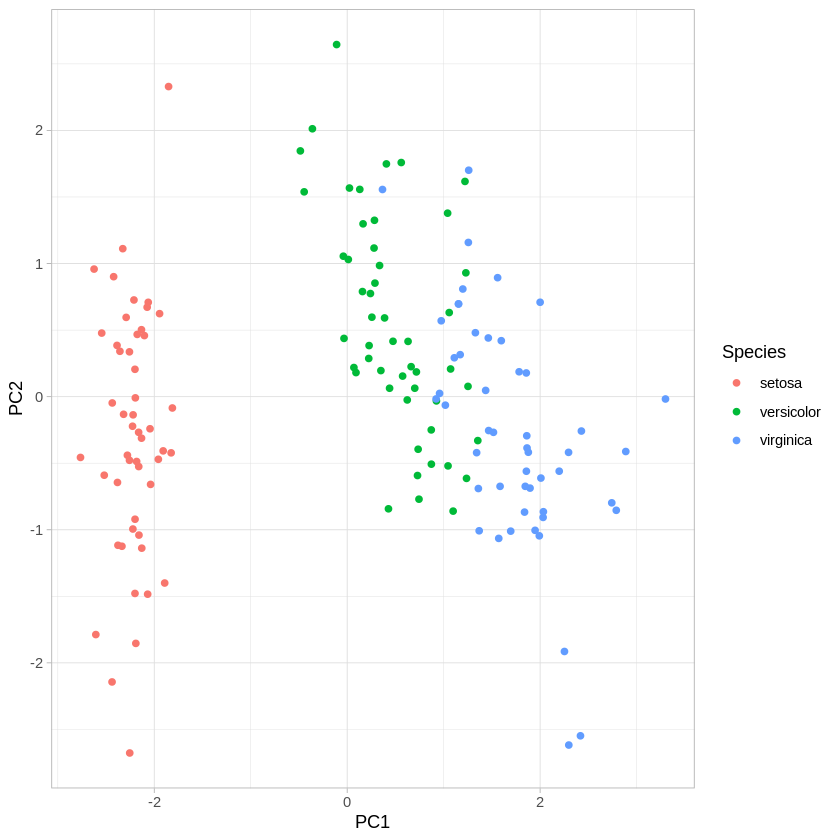

In [40]:
ggplot(data.frame(PC1=iris.pca$x[,1],PC2=iris.pca$x[,2],Species=iris$Species),
        aes(x=PC1,y=PC2,col=Species)) + 
    geom_point() + 
    theme_light()

We can see that the first two PCs do a pretty good job of capturing the variance across the four original variables. Compare this plot to the two original scatter plots. Reason about why it looks the way it does, given how the first two PCs drew from the original variables. 

---
# Principal component regression

Now that we've got a firmer grasp on what PCA is doing generally, let's try out principal component regression using the `pcr()` function from the `pls` library. We'll use the `Hitters` dataset for this example. 

In [61]:
install.packages("pls") # Uncomment if not installed
library(pls) # load for the pcr function
install.packages("ISLR") # Uncomment if not installed
library(ISLR) # For Hitters dataset
library(tidyverse)
hit.dat <- Hitters %>% drop_na() # get rid of missing values in Hitters dataset.

Let's apply PCR to the `Hitters` dataset, trying to predict `Salary`. The `scale` input just indicates that we want to scale the variables prior to dimensionality reduction, and setting `validation` to "CV" triggers the use of 10-fold cross validation to evaluate the number of PCs to use. 

In [64]:
set.seed(2)
pcr.fit=pcr(Salary~., data=hit.dat ,scale=TRUE, validation ="CV")
summary(pcr.fit)

Data: 	X dimension: 263 19 
	Y dimension: 263 1
Fit method: svdpc
Number of components considered: 19

VALIDATION: RMSEP
Cross-validated using 10 random segments.
       (Intercept)  1 comps  2 comps  3 comps  4 comps  5 comps  6 comps
CV             452    351.9    353.2    355.0    352.8    348.4    343.6
adjCV          452    351.6    352.7    354.4    352.1    347.6    342.7
       7 comps  8 comps  9 comps  10 comps  11 comps  12 comps  13 comps
CV       345.5    347.7    349.6     351.4     352.1     353.5     358.2
adjCV    344.7    346.7    348.5     350.1     350.7     352.0     356.5
       14 comps  15 comps  16 comps  17 comps  18 comps  19 comps
CV        349.7     349.4     339.9     341.6     339.2     339.6
adjCV     348.0     347.7     338.2     339.7     337.2     337.6

TRAINING: % variance explained
        1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps  8 comps
X         38.31    60.16    70.84    79.03    84.29    88.63    92.26    94.96
Salary    4

The `% variance explained` section of the output above shows us the cumulative variance explained by each additional PC, reaching 100% after 19 PCs. Since there were 19 variables to start with (not counting `Salary`, since that's our dependent variable), this makes sense since unless some variables contribute no information at all, you'll need the same number of PCs to explain all variance as the number of variables you originally put in. The first 5 PCs explain 84% of the variance in the data. 

The `VALIDATION` section of the output above shows us the cross-validated root mean squared-error for each number of components used (we can just square this to get the normally used mean squared-error). We can also visualize this using the `validationplot()` function.

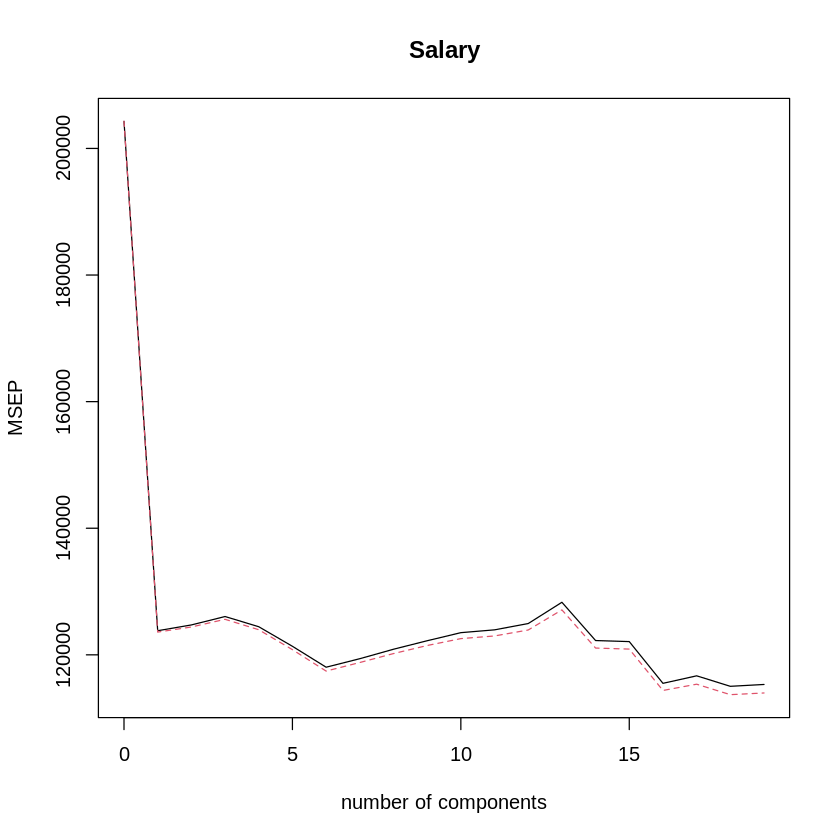

In [65]:
validationplot(pcr.fit,val.type="MSEP") # MSEP shows cross-validated mean-squared error as error metric. 

The best performance is around 16 PCs, but it looks like that doesn't do much better than 6 PCs. 

Let's try this again, fitting and cross-validating PCR with a training subset and then testing it on the remaining data. 

In [74]:
set.seed(1)
train=sample(1:nrow(hit.dat), nrow(hit.dat)/2) # Identify train observations
test=(-train) # Identify test observations
y.test=hit.dat$Salary[test] # Identify test dependent variable values
x.test=select(hit.dat,-Salary)[test,] # Identify test independent variable values

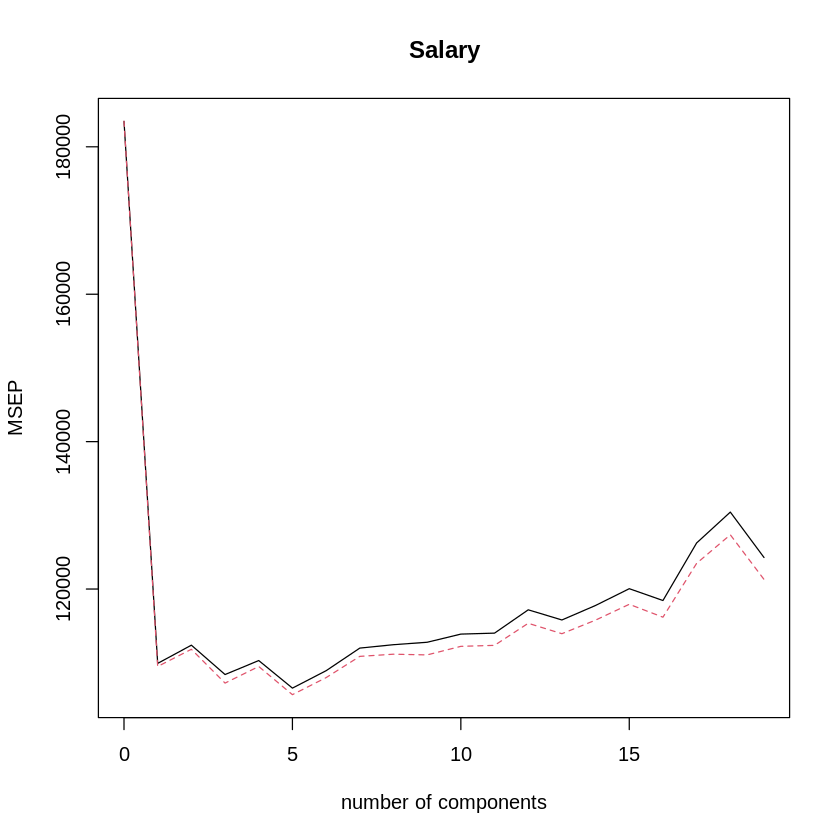

In [75]:
pcr.fit=pcr(Salary~., data=hit.dat,subset=train,scale=TRUE, validation ="CV") # Run cross-validated PCR fit on training set
validationplot(pcr.fit,val.type="MSEP") # plot CV MSE for num of PCs

It looks like, for the training set, the best number of PCs is 5. How does that look on the test set? 

In [78]:
# calculate prediction error on test set 
pcr.pred=predict(pcr.fit,x.test,ncomp=5)
mean((pcr.pred-y.test)^2)

[1] 142811.8

Now that we've got a good model selected (with M = 7 principal components), let's fit it to the whole dataset.

In [80]:
pcr.fit = pcr(Salary~., data=hit.dat, scale=TRUE, ncomp=5) # fit PCR to the full data set using our selected number of PCs, M = 5
summary(pcr.fit)

Data: 	X dimension: 263 19 
	Y dimension: 263 1
Fit method: svdpc
Number of components considered: 5
TRAINING: % variance explained
        1 comps  2 comps  3 comps  4 comps  5 comps
X         38.31    60.16    70.84    79.03    84.29
Salary    40.63    41.58    42.17    43.22    44.90


---
# Partial least squares

The function for performing partial least squares is `plsr()`, also in the `pls` package. Let's apply cross-validated PLS to the `Hitters` training dataset, again trying to predict `Salary`. 

In [82]:
set.seed(1)
pls.fit <- plsr(Salary~.,data = hit.dat, subset=train, scale=TRUE, validation="CV")
summary(pls.fit)

Data: 	X dimension: 131 19 
	Y dimension: 131 1
Fit method: kernelpls
Number of components considered: 19

VALIDATION: RMSEP
Cross-validated using 10 random segments.
       (Intercept)  1 comps  2 comps  3 comps  4 comps  5 comps  6 comps
CV           428.3    325.5    329.9    328.8    339.0    338.9    340.1
adjCV        428.3    325.0    328.2    327.2    336.6    336.1    336.6
       7 comps  8 comps  9 comps  10 comps  11 comps  12 comps  13 comps
CV       339.0    347.1    346.4     343.4     341.5     345.4     356.4
adjCV    336.2    343.4    342.8     340.2     338.3     341.8     351.1
       14 comps  15 comps  16 comps  17 comps  18 comps  19 comps
CV        348.4     349.1     350.0     344.2     344.5     345.0
adjCV     344.2     345.0     345.9     340.4     340.6     341.1

TRAINING: % variance explained
        1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps  8 comps
X         39.13    48.80    60.09    75.07    78.58    81.12    88.21    90.71
Salary 

Interestingly, the lowest RMSE is when only one partial least squares direction is used. Let's look at how a model with only one PLS direction performs on the test data.

In [83]:
pls.pred = predict(pls.fit,x.test,ncomp=1)
mean((pls.pred - y.test)^2)

[1] 151995.3

This is higher than the test error we got using 5 principal components in the PCR example above, but still comparable. Now let's look at PLS for the full data set, using M = 1.

In [85]:
pls.fit = plsr(Salary~.,data=hit.dat,scale=TRUE,ncomp=1)
summary(pls.fit)

Data: 	X dimension: 263 19 
	Y dimension: 263 1
Fit method: kernelpls
Number of components considered: 1
TRAINING: % variance explained
        1 comps
X         38.08
Salary    43.05


Note that the amount of variance in `Salary` explained by the one-component PLS fit, 43.05%, is similar to that explained by four principal components, 43.22%, in the PCR example. This is because, while PCR is only trying to maximize variance explained in the predictor variables, PLS is trying to maximize variance explained in both the predictors and the response. 

*Notebook authored by Patience Stevens and edited by Amy Sentis.*